# Micromorph: Computational Science

## **Jed Brown**, CU Boulder

### Ratel: Grain-resolved implicit FE/MPM
* Ren Stengel, Jeremy L. Thompson (CU)

### GEOSX: Grain-resolved explicit (for now) MPM
* Jay Appleton (CU)

### Chamois: Micropolar plasticity
* Matthias Neuner (Stanford)

### LAMMPS: DEM
* Sam Lamont (CU)

### ParaEllip3d-CFD: DEM
* Beichuan Yan (CU)

### Tardigrade: Micromorphic
* Thomas Allard (CU), Nathan Miller (LANL)

## TST meeting, Boulder, 2022-05-25

In [13]:
from IPython.display import SVG, Video, HTML, IFrame
import pandas as pd
import altair as alt
from io import StringIO
import numpy as np


## PSAAP: Micromorphic and grain-resolving composite inelasticity

<img src="figures/micromorph/workflow.png" />

# Ratel: implicit solid mechanics

<video src="figures/ratel/schwarz-q2-5x5x5-t20-l2-r2.ogv" width="90%" autoplay controls loop />

<video src="figures/ratel/schwarz-pendulum.webm" autoplay loop controls width="100%" />

# Ratel: holistic approach to efficient accuracy


## Industrial state of practice

* Low order finite elements: $Q_1$ (trilinear) hexahedra, $P_2$ (quadratic) tetrahedra.
* Assembled matrices, sparse direct and algebraic multigrid solvers

## Myths

* High order doesn't help because real problems have singularities.
* Matrix-free methods are just for high order problems

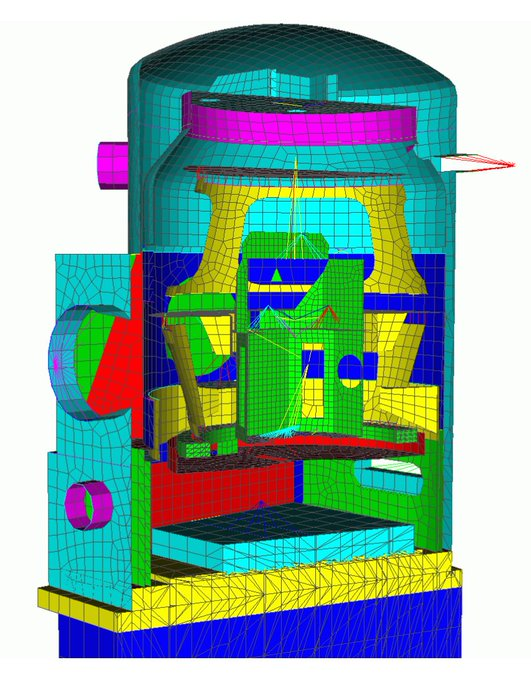

* Every reentrant corner
* Every Dirichlet (fixed/clamped) to Neumann boundary transition

(From Bhardwaj et al, 2002.)

# Approximation constants are good for high order

<img src="figures/ratel/accuracy_study_annotated.svg" width="85%" />

# Spurious stress singularities

<img src="figures/ratel/refinement_mesh.png" width="100%" />

* Geometric model has a round cylinder, no singularity
* Linear meshes have weak reentrant corners
* Moving to quadratic geometry elements is generally good enough
* Gmsh supports arbitrary order

<video src="figures/ratel/one-hole-traction-20220222.ogv" autoplay controls loop />

# Why matrix-free?

* Assembled matrices need at least 4 bytes transferred per flop. Hardware does 10 flops per byte.
* Matrix-free methods store and move less data, compute faster.

<img src="figures/karlrupp/flop-per-byte-dp-2021.svg" class="floatleft" />
<img src="figures/TensorVsAssembly-qstore.svg" class="floatright" />

# Matrix-free is already faster for $Q_1$ elements

<img src="figures/ratel/schwarz-apply.svg" width="100%" />

# $p$-multigrid algorithm and cost breakdown

<img src="figures/ratel/p-mg-cycle.png" width="80%" />

<img src="figures/ratel/op_schematic.svg" width="80%" />

In [14]:
IFrame("figures/ratel/schwarz-q2-flame.svg", width="2000", height="350")

# Programmability

## Single-source with JIT

* Ratel compiles with a plain C compiler
  * You're welcome to use C++, etc,, but that's the materials author's choice
* Its GPU performance is state of the art
  * Just-in-time compilation with kernel fusion
* End-to-end solve on GPU
  * GPU-aware MPI
  * Sparse matrix assembly
  * Algebraic multigrid setup
* Libraries like MFEM and PETSc for broader use

## Enzyme

* LLVM plugin, loadable with JIT within ROCm
* Differentiate LLVM intermediate representation (IR) (cf. Abaqus [UHYPER](https://abaqus-docs.mit.edu/2017/English/SIMACAESUBRefMap/simasub-c-uhyper.htm#simasub-c-uhyper))

```c
double StrainEnergy(const double E[6]) {
  double I1 = Trace(E), I2 = Second(E);
  double logJ = log1p(Jm1(E));
  return .5*lambda*logJ*logJ
        - (mu1 + 2*mu2)*logJ
        + .5*mu1*I1 + .5*mu2*I2;
}
```
```c
void Stress(const double E[6],
            double S[6]) {
  return __enzyme_autodiff(
      StrainEnergy, E, S);
}
```

# Nonlinear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-SNESSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-SNESSolve.svg" />

# Linear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-KSPSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-KSPSolve.svg" />

* Coarse solver is hypre BoomerAMG tuned configured for elasticity; thanks Victor Paludetto
Magri.

# Preconditioner setup efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-PCSetUp.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-PCSetUp.svg" />

# One node of Crusher vs historical Gordon Bell
## 184 MDoF $Q_2$ elements nonlinear analysis in seconds

## 2002 Gordon Bell (Bhardwaj et al)

<img src="figures/ratel/gordon-bell-2002-mems.png" width="70%" />

<img src="figures/ratel/gordon-bell-2002-mems-table.png" width="100%" />

## 2004 Gordon Bell (Adams et al)

<img src="figures/ratel/gordon-bell-2004-bone.png" width="70%" />

<img src="figures/ratel/gordon-bell-2004-bone-scaling.jpg" width="100%" />

## [libCEED](https://libceed.readthedocs.io): fast algebra for finite elements

* Backend plugins with run-time selection
  * debug/memcheck, optimized
  * libxsmm, CUDA, HIP
  * MAGMA to CUDA and HIP
  * OCCA to OpenMP, OpenCL, CUDA, and HIP
* Single source vanilla C for QFunctions
  * Easy to debug, understand locally, C++ optional
  * Target for DSLs, AD
* Python, Julia, Rust
* 2-clause BSD
* Available via MFEM, PETSc, Nek5000

<img src="figures/ceed/libceed-backends-tex.png" />

Thanks to many contributors, including Jeremy Thompson, Yohann Dudouit, Valeria Barra, Natalie Beams,  Ahmad Abdelfattah, Leila Ghaffari, Will Pazner, Thilina Ratnayaka, Tzanio Kolev, Veselin Dobrev, David Medina

<img src="figures/ceed/libCEED-2.png" width=100% />


## Quadrature functions: the math

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    u = B_I \mathcal E_e u_L \qquad \nabla u = \frac{\partial X}{\partial x} B_{\nabla} \mathcal E_e u_L \\
    J w = \sum_e \mathcal E_e^T \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix}}_{\text{coefficients at quadrature points}} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix} \mathcal E_e w_L
\end{gather*}
  
* $B_I$ and $B_\nabla$ are tensor contractions -- independent of element geometry
* Choice of how to order and represent gathers $\mathcal E$ and scatters $\mathcal E^T$
* Similar for Neumann/Robin and nonlinear boundary conditions

## Quadrature functions: debuggable, vectorizable, and JITable

* Independent operations at each of `Q` quadrature points, order unspecified

```c
int L2residual(void *ctx, CeedInt Q,
    const CeedScalar *const in[],
    CeedScalar *const out[]) {
  const CeedScalar *u = in[0], *rho = in[1], *target = in[2];
  CeedScalar *v = out[0];
  for (CeedInt i=0; i<Q; i++)
    v[i] = rho[i] * (u[i] - target[i]);
  return 0;
}
```

![](figures/ceed/solids-perf-disassembly.png)

# Vector hand-off

```c
  DMGlobalToLocal(ctx->dm_x, X, INSERT_VALUES, ctx->X_loc);

  // Setup libCEED vectors
  VecGetArrayReadAndMemType(ctx->X_loc, &x, &x_mem_type);
  VecGetArrayAndMemType(ctx->Y_loc, &y, &y_mem_type);
  CeedVectorSetArray(ctx->x_loc_ceed, P2C(x_mem_type), CEED_USE_POINTER, x);
  CeedVectorSetArray(ctx->y_loc_ceed, P2C(y_mem_type), CEED_USE_POINTER, y);

  // Apply libCEED operator
  CeedOperatorApply(ctx->op, ctx->x_loc_ceed, ctx->y_loc_ceed, CEED_REQUEST_IMMEDIATE);

  // Restore PETSc vectors
  CeedVectorTakeArray(ctx->x_loc_ceed, P2C(x_mem_type), NULL);
  CeedVectorTakeArray(ctx->y_loc_ceed, P2C(y_mem_type), NULL);
  VecRestoreArrayReadAndMemType(ctx->X_loc, &x);
  VecRestoreArrayAndMemType(ctx->Y_loc, &y);

  DMLocalToGlobal(ctx->dm_y, ctx->Y_loc, ADD_VALUES, Y);
```

# Matrix assembly

## Symbolic: once for matrix structure
```c
PetscInt *rows, *cols;
CeedOperatorLinearAssembleSymbolic(op_ceed, &num_entries, &rows, &cols);
MatSetPreallocationCOOLocal(A, num_entries, rows, cols);
free(rows);
free(cols);
```

## Numeric
```c
CeedVector values_ceed;
PetscScalar *values;

CeedOperatorLinearAssemble(op_ceed, coo_values_ceed);
CeedVectorGetArrayRead(coo_values_ceed, ceed_memory_space, &values);
MatSetValuesCOO(A, values, INSERT_VALUES);
```

# libCEED and PETSc asynchrony

![](figures/ceed/libceed-bp3-nsys-cuda-gen.png)

# libCEED solid mechanics flame graphs

In [15]:
IFrame("data/ceed/noether/noether-solids-holes-P4-xsmm-coo.svg", width="1600", height="900")

# Solids: efficient matrix-free Jacobians
## cf. [Davydov et al. (2020)](https://doi.org/10.1002/nme.6336)

<img src="figures/ceed/libceed-solids-initial-current.png" width="80%" />
<img src="figures/ceed/libceed-solids-jacobian-table.png" width="80%" />

# Grain-resolving setup

## STL/unstructured workflow

* Import STL grains into Gmsh, mesh within cylinder
* Unstructured tet mesh of total geometry
* Variant: infer parametric surface from STL; mesh with different size/topology elements
* Conforms to initial surfaces, smooth friction

## Voxel workflow
* Sample to voxels of arbitrary size
* Each voxel (or material point) is uniquely classified
* Element "quality" is good, but interfaces are stepped
* Finer meshes needed for accuracy

<img src="figures/micromorph/gmsh-one-grain-in-cylinder.png" />

<img src="figures/micromorph/gmsh-one-grain-in-cylinder-tets.png" />

<div class="floatleft80">
    
# Outlook: https://ratel.micromorph.org
</div>

<div class="floatright20">
     
[![GitLab-CI](https://gitlab.com/micromorph/ratel/badges/main/pipeline.svg?key_text=GitLab-CI)](https://gitlab.com/micromorph/ratel/-/pipelines?page=1&scope=all&ref=main)
[![BSD-2-Clause](https://img.shields.io/badge/License-BSD%202--Clause-orange.svg)](https://opensource.org/licenses/BSD-2-Clause)
[![Documentation](https://img.shields.io/badge/Documentation-latest-blue.svg)](https://ratel.micromorph.org)
[![Code Coverage](https://gitlab.com/micromorph/ratel/badges/main/coverage.svg)](https://gitlab.com/micromorph/ratel/-/commits/main) 
     
</div>

## The good

* Productive, debuggable materials development
* You can move from $Q_1$ to $Q_2$ elements for about 2x cost (despite 8x more DoFs)
* libCEED isn't just for high order; already 2x operator apply benefit for $Q_1$
* Gordon Bell scale from 20 years ago $\mapsto$ interactive on a workstation (if you can buy MI250X 😊)
* $p$-multigrid, low-memory representation of matrix-free Jacobian
* Multi-node GPU on CUDA and ROCm
* Also good for implicit dynamics
* UQ in the loop, amortize

https://arxiv.org/abs/2204.01722

## Needs/questions

* Focus: **materials**
* How important is friction/sliding between grains? Conformal versus voxelized MPM?
* What resolution will be needed to predict QoI of pressing (which has plastic yielding)?
* Large time steps are stable; what about accuracy?
* How many realizations for converged statistics?

<img src="figures/micromorph/gmsh-stl-grain-with-loop.png" />

# GEOSX

* Basic MPI parallel MPM is working is GEOSX
* Porting full GEOS-MPM capabilities to GEOSX over the summer
* Jay Appleton will work on **profiling/optimization** and **GPU porting** this summer
* Yohann Dudouit (CEED team member at LLNL) joining the project.

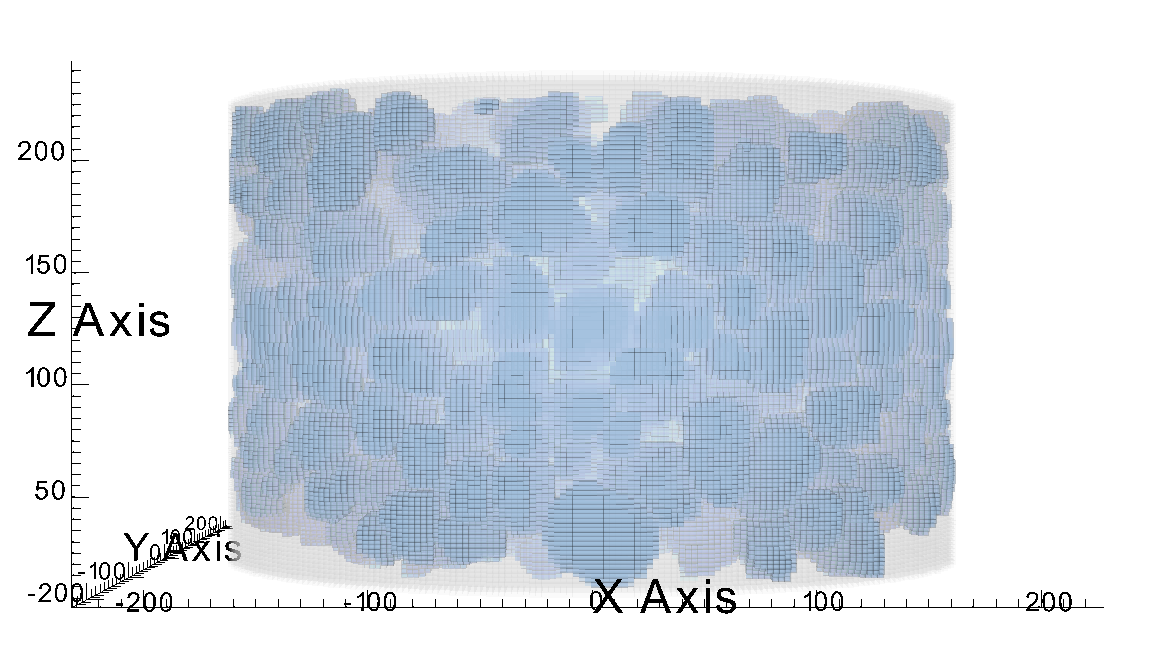
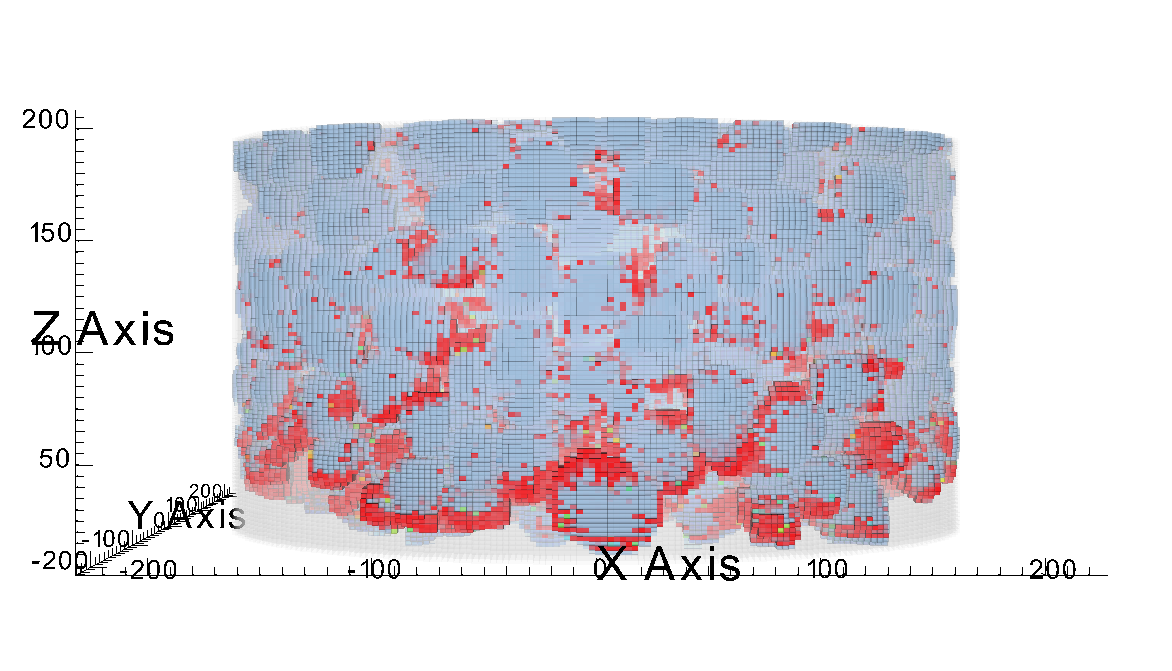

# LAMMPS (Sam Lamont)

* Bonded particle models for grains (large and irregular)
* Spring network for binder
* Sam Lamont will experiment with GPU efficiency/scaling, granular capability
* Calibrating particle parameters to match desired macroscopic moduli

In [16]:
IFrame("figures/micromorph/lammps-flame-sam-lamont-20220524.svg", width="1200", height="700")

# ParaEllip3d-CFD (Beichuan Yan)

* Improved particle generating algorithm in terms of cumulative particle size distribution curves.
* Improved algorithm for fine particle packing/deposition simulations: (1) developed a new spatial densification generating algorithm; (2) adopted “duplicate-and-merge” method to speed up particle packing.
* Performed larger-scale Direct Simple Shear (DSS) simulations on Quartz (100k particles, quasi-static, 27 nodes) for DEM-to-continuum upscaling research.
* 163 new commits at Gitlab since 09/15/2021.

<img src="figures/micromorph/paraellip3d-figures-202205.png" />

# ParaEllip3d-CFD ongoing activities

* Developing model and algorithm for “binder as particles”: small particle adhered together and applied “particle-spring-network” to simulate binder.
* Developing uniaxial unconfined compression (and/or extension) tests to calibrate the binder materials against experiments.
* Integrating other non-symmetric matrix eigen-solvers (Eigen, Lapack, Magma) into ParaEllip3d to performance evaluation and exploring CUDA accelerating possibilities.
* Migrating visualization from Tecplot to ParaView/VISIT.

<div class="floatleft80">

# Chamois: https://matthiasneuner.github.io/chamois/
</div>

<img src="figures/micromorph/chamois/202205/chamois_logo.png" class="floatright20" width="15%" />

* MOOSE application
* Micropolar formulation (subset of micromorphic; fewer parameters)
* MPI parallel, simulations with 30 MDoF
* Key use of hypre BoomerAMG and PETSc

<video src="figures/micromorph/chamois/202205/gosford_triax.mp4" autoplay loop />

# Chamois flame graph

In [17]:
IFrame("figures/micromorph/chamois/202205/flamegraph_20x40_elements.svg", width="1200", height="700")

# Social/integration activities

## Biweekly performance hacking

* Students, research associates, faculty
* Present new results from a performance/algorithmic lens
* Demo tools and success stories
* Dig into diagnostics, obstacles
* Design of performance studies and presentation of results
  * Help analyst decide what they can run where

## DevOps and software engineering

* Continuous integration
  * Including CUDA and ROCm
* How to test effectively
* Writing documentation (code, usage, and theory)
* Software engineering, effective use of libraries
* Preparing merge requests
* Reviewing code

<img src="figures/micromorph/workflow.png" />